In [1]:
import numpy as np
import gym
from gym.spaces import Discrete, Box
import torch.nn as nn
import torch
import torch.optim as optimizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class MLP(nn.Module):
    """
    Returns a fully connected neural network of 
    given dimensions. The input is of dimensions
    of the shape of the observations and output
    is of the shape of number of actions.
    """

    def __init__(self, sizes, activation=nn.ReLU(inplace=True), output_activation=None):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes) - 2:
                layers.append(activation)
        self.fwd = nn.Sequential(*layers)
    
    def forward(self, x):
        return F.softmax(self.fwd(x), dim=-1)

In [3]:
def discount_rewards(rewards, gamma=0.99):
    # Cumulative discounted sum
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    r = r[::-1].cumsum()[::-1]
    # Subtracting the baseline reward 
    # Intuitively this means if the network predicts what it
    # expects it should not do too much about it
    # Stabalizes and speeds up the training 
    return r - r.mean()

In [4]:
def select_device(device=''):
    if device.lower() == 'cuda':
        if not torch.cuda.is_available():
            print ("torch.cuda not available")
            return torch.device('cpu')    
        else:
            return torch.device('cuda:0')
    if device.lower() == 'dml':
        return torch.device('dml')
    else:
        return torch.device('cpu')

In [5]:
device = select_device("cpu")
print(device)

cpu


In [14]:
def train(env_name='CartPole-v0', num_episodes=2000, batch_size=10, lr=1e-2, gamma=0.99):

    env = gym.make(env_name)
    model = MLP([env.observation_space.shape[0], 32, 20, env.action_space.n])
    model.to(device)
    # Lists for maintaing logs
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []

    batch_counter = 1
    opt = optimizer.Adam(model.parameters(), lr)
    action_space = np.arange(env.action_space.n)

    for ep in tqdm(range(num_episodes)):
        # Reset
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        complete = False
        while complete == False:
            action_probs = model(torch.FloatTensor(s_0)).to(device).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s1, r, complete, _ = env.step(action)
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s1
            if complete:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))

                if batch_counter == batch_size:
                    # Prepare the batches for training
                    # Add states, reward and actions to tensor
                    opt.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)

                    # Convert the probs by the model to log probabilities
                    log_probs = torch.log(model(state_tensor))
                    # Mask the probs of the selected actions
                    selected_log_probs = reward_tensor * log_probs[np.arange(len(action_tensor)), action_tensor]
                    # Loss is negative of expected policy function J = R * log_prob
                    loss = -selected_log_probs.mean()

                    # Do the update gradient descent(with negative reward hence is gradient ascent) 
                    loss.backward()
                    opt.step()

                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1

                print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
    
    return total_rewards

In [15]:
rewards = train()
window = 10
smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                    else np.mean(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.plot(smoothed_rewards)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

In [6]:
env = gym.make('CartPole-v0')
model = MLP([env.observation_space.shape[0], 32, 20, env.action_space.n])
# Lists for maintaing logs
total_rewards = []
batch_rewards = []
batch_actions = []
batch_states = []

batch_counter = 1
opt = optimizer.Adam(model.parameters(), 1e-2)
action_space = np.arange(env.action_space.n)

for ep in tqdm(range(2000)):
    # Reset
    s_0 = env.reset()
    states = []
    rewards = []
    actions = []
    complete = False
    while complete == False:
        action_probs = model(torch.FloatTensor(s_0)).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)
        s1, r, complete, _ = env.step(action)
        states.append(s_0)
        rewards.append(r)
        actions.append(action)
        s_0 = s1
        if complete:
            batch_rewards.extend(discount_rewards(rewards, 0.99))
            batch_states.extend(states)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            if batch_counter == 10:
                # Prepare the batches for training
                # Add states, reward and actions to tensor
                opt.zero_grad()
                state_tensor = torch.FloatTensor(batch_states)
                reward_tensor = torch.FloatTensor(batch_rewards)
                action_tensor = torch.LongTensor(batch_actions)

                # Convert the probs by the model to log probabilities
                log_probs = torch.log(model(state_tensor))
                # Mask the probs of the selected actions
                selected_log_probs = reward_tensor * log_probs[np.arange(len(action_tensor)), action_tensor]
                # Loss is negative of expected policy function J = R * log_prob
                loss = -selected_log_probs.mean()

                # Do the update gradient descent(with negative reward hence is gradient ascent) 
                loss.backward()
                opt.step()

                batch_rewards = []
                batch_actions = []
                batch_states = []
                batch_counter = 1

            print("\rEp: {} Average of last 10: {:.2f}".format(
                ep + 1, np.mean(total_rewards[-10:])), end="")

  0%|          | 0/2000 [00:00<?, ?it/s]

Ep: 8 Average of last 10: 21.38

/home/vedang/miniconda3/envs/drone2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180593867/work/torch/csrc/utils/tensor_new.cpp:201.)


Ep: 2000 Average of last 10: 200.00

In [7]:
env = gym.make('CartPole-v0')
model = MLP([env.observation_space.shape[0], 32, 20, env.action_space.n])
model.to(device)
# Lists for maintaing logs
total_rewards = []
batch_rewards = []
batch_actions = []
batch_states = []

batch_counter = 1
opt = optimizer.Adam(model.parameters(), 1e-2)
action_space = np.arange(env.action_space.n)

for ep in tqdm(range(2000)):
    # Reset
    s_0 = env.reset()
    states = []
    rewards = []
    actions = []
    complete = False
    while complete == False:
        action_probs_ = model(torch.FloatTensor(s_0).to(device)).to(device)
        action_probs = action_probs_.cpu().detach().numpy()
        action = np.random.choice(action_space, p=action_probs)
        s1, r, complete, _ = env.step(action)
        states.append(s_0)
        rewards.append(r)
        actions.append(action)
        s_0 = s1
        if complete:
            batch_rewards.extend(discount_rewards(rewards, 0.99))
            batch_states.extend(states)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            if batch_counter == 10:
                # Prepare the batches for training
                # Add states, reward and actions to tensor
                opt.zero_grad()
                state_tensor = torch.FloatTensor(batch_states).to(device)
                reward_tensor = torch.FloatTensor(batch_rewards).to(device)
                action_tensor = torch.LongTensor(batch_actions).to(device)

                # Convert the probs by the model to log probabilities
                log_probs = torch.log(model(state_tensor))
                # Mask the probs of the selected actions
                selected_log_probs = reward_tensor * log_probs[np.arange(len(action_tensor)), action_tensor]
                # Loss is negative of expected policy function J = R * log_prob
                loss = -selected_log_probs.mean().to(device)

                # Do the update gradient descent(with negative reward hence is gradient ascent) 
                loss.backward()
                opt.step()

                batch_rewards = []
                batch_actions = []
                batch_states = []
                batch_counter = 1

            print("\rEp: {} Average of last 10: {:.2f}".format(
                ep + 1, np.mean(total_rewards[-10:])), end="")

  0%|          | 0/2000 [00:00<?, ?it/s]

Ep: 17 Average of last 10: 18.10

/home/vedang/miniconda3/envs/drone2/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180593867/work/torch/csrc/utils/tensor_new.cpp:201.)


Ep: 844 Average of last 10: 200.00

KeyboardInterrupt: 

In [9]:
import time
total_epochs, total_penalties = 0, 0
episodes = 100
frames = []
action_space = np.arange(env.action_space.n)

for ep in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    # print(ep)
    while not done or epochs>int(100):
        # action = np.argmax(q_table[state])
        action_probs = model(torch.FloatTensor(s_0)).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
        
        # Put each rendered frame into dict for animation
        if ep%10 == 0:
            mo = 'human'
            time.sleep(0.02)
        else:
            mo = 'ansi'
        frames.append({
            'frame': env.render(mode=mo),
            'episode': ep, 
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 9.62
Average penalties per episode: 0.0


In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        # plt.imshow(frame['frame'])
        # print(f"")
        print(f"Episode: {frame['episode']}")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(0.02)

In [11]:
print_frames(frames)

Episode: 99
Timestep: 962
State: [ 0.20061387  1.98832831 -0.24577728 -3.08309314]
Action: 1
Reward: 1.0


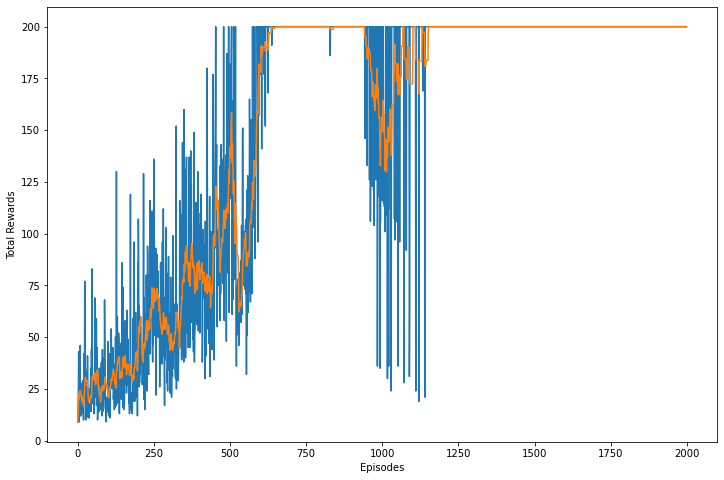

In [12]:
rewards = total_rewards
window = 10
smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                    else np.mean(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.plot(smoothed_rewards)
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.show()